# Image Similarity Modeling and Analysis with PyTorch

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Batch Inference](#Inference)

---

## Background

In this notebook you will build a model to measure the similarity between products from the Zappos product catalog. This notebook uses the [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/) data set provided by University of Texas at Austin. The data has been processed and was scraped off the Zappos.com website, and is intended for non-commerical use.

In this example, we will leverage a CNN based siamese network to learn the similarity function between the products in the catalog. The model is built on PyTorch and trained on SageMaker, and uses transfer learning techniques to leverage pre-trained ResNet models. Finally, the notebook demonstrates how to use SageMaker's Batch Inference functionality to produce a batch of similiarity measures between images using the trained siamese network.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) Github repositories.

---

## Setup

_This notebook was tested on an ml.t2.2xlarge, ml.p2.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).


In [1]:
import os
import sagemaker

SOURCE_DIR='source/similarity'
WORKING_DIR = os.getcwd()

sagemaker_session = sagemaker.Session()

SAGEMAKER_BUCKET = sagemaker_session.default_bucket()
prefix = '/sagemaker/DEMO-pytorch-siamese-network/data'

role = sagemaker.get_execution_role()
DATA_S3URI = "s3://"+SAGEMAKER_BUCKET+prefix

print("Your SageMaker bucket: "+SAGEMAKER_BUCKET)
print("Current working directory: "+WORKING_DIR)
print("S3 location for storing training data: " + DATA_S3URI)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-777141646116


Your SageMaker bucket: sagemaker-us-east-1-777141646116
Current working directory: /home/ec2-user/SageMaker
S3 location for storing training data: s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data


Take note of your SageMaker bucket. You'll need to reference it later in this lab.

Next, specify the region where you're running this lab.

In [2]:
#WORKSHOP_REGION = 'us-west-2'
WORKSHOP_REGION = '<<SET YOUR REGION>>'

## Data

The original dataset can be downloaded from [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/). The dataset has been made available at the following S3 bucket to offload the original site.

In [3]:
DOWNLOAD_S3URI = "s3://reinvent2018-sagemaker-pytorch"

Let's preview one of the images from the data set.

In [4]:
%%bash -s "$DOWNLOAD_S3URI" "$WORKING_DIR"

mkdir -p $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/
aws s3 cp $1/data/raw/Boots/Knee\ High/Anne\ Klein/8059298.310.jpg $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/

download: s3://reinvent2018-sagemaker-pytorch/data/raw/Boots/Knee High/Anne Klein/8059298.310.jpg to ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg


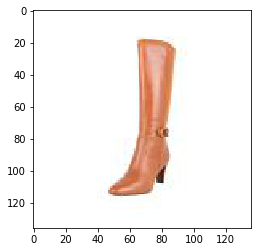

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(WORKING_DIR+"/ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg")
plt.imshow(img)

### Uploading the data to S3

We are going to transfer a subset of the Zappos50k dataset over to the default SageMaker bucket in your account. Training on the entire dataset will take hours on GPU as it involves training on a very large dataset of image pair combinations. The goal of this notebook is to demonstrate the process by training on a small subet of the images. 

All the images, processed inputs, and indexes for the entire dataset are publicly shared in the same S3 download location if you wish to experiment on the entire dataset. [Utility scripts](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/notebooks/pytorch_siamese_network_utils.ipynb) have also been made public for you to leverage if you wish to generate your own indexes and pre-processed dataset (npy tensors). 

First we download a list of images that describes the subset of images we're going to experiment with.

In [7]:
import time
import pandas as pd

SAMPLE_IMAGES_FILE = "sample_images.csv"
os.system("aws s3 cp "+DOWNLOAD_S3URI+"/"+SAMPLE_IMAGES_FILE + " "+WORKING_DIR)
df = pd.read_csv(WORKING_DIR+"/"+SAMPLE_IMAGES_FILE, header=None, usecols=[0], names=['img'])
IMG_PATHS = df['img'].tolist()

start = time.time()

for paths in IMG_PATHS :
    esc_path = paths.replace(' ','\ ')
    os.system('aws s3 sync ' + (DOWNLOAD_S3URI+"/data/raw/"+esc_path) +
              ' '+ DATA_S3URI+'/'+esc_path +
              ' --quiet --source-region us-west-2 --region '+ WORKSHOP_REGION)

end = time.time()
print("Sync completed in "+ str(int(end - start))+" seconds")

Sync completed in 42 seconds


### PyTorch DataSet indexes

Now we copy over index files that have been generated for you. These indexes will be used by the training script to locate selected images during training.

The script expects indexes named as follows for the training and test sets respectively:
    - zappos50k-tuples-index-train.csv
    - zappos50k-tuples-index-test.csv

In [8]:
%%bash -s "$DOWNLOAD_S3URI" "$DATA_S3URI" "$WORKSHOP_REGION"

aws s3 cp $1/zappos50k-partial-tuples-index-test.csv $2/ --source-region us-west-2 --region $3
aws s3 cp $1/zappos50k-partial-tuples-index-train.csv $2/ --source-region us-west-2 --region $3

aws s3 mv $2/zappos50k-partial-tuples-index-train.csv $2/zappos50k-tuples-index-train.csv --quiet
aws s3 mv $2/zappos50k-partial-tuples-index-test.csv $2/zappos50k-tuples-index-test.csv  --quiet

copy: s3://reinvent2018-sagemaker-pytorch/zappos50k-partial-tuples-index-test.csv to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-test.csv
copy: s3://reinvent2018-sagemaker-pytorch/zappos50k-partial-tuples-index-train.csv to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-train.csv


### Pre-trained model artifacts

Next, we copy over the artifacts for a pre-trained version of the model that we'll be creating in the following steps. This pre-trained model will be used later in the lab.

In [9]:
MODELS_S3URI = "s3://"+SAGEMAKER_BUCKET+'/sagemaker/DEMO-pytorch-siamese-network/model'

In [10]:
%%bash -s "$DOWNLOAD_S3URI" "$MODELS_S3URI" "$WORKSHOP_REGION"

START_TIME=$SECONDS

aws s3 sync $1/models/v2 $2 --source-region us-west-2 --region $3

DURATION=$(($SECONDS - $START_TIME))
echo Sync completed in $DURATION seconds

copy: s3://reinvent2018-sagemaker-pytorch/models/v2/source/sourcedir.tar.gz to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/model/source/sourcedir.tar.gz
copy: s3://reinvent2018-sagemaker-pytorch/models/v2/output/model.tar.gz to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/model/output/model.tar.gz
copy: s3://reinvent2018-sagemaker-pytorch/models/v2/output/output.tar.gz to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/model/output/output.tar.gz
Sync completed in 24 seconds


## Train

We need to provide a training script that can run on the SageMaker platform. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

    SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
    SM_OUTPUT_DATA_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

    SM_CHANNEL_TRAINING: A string representing the path to the directory containing data in the 'training' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance. For example, the script run by this notebook:

Download the provided scripts from S3:

    - cnn.py: this script implements a siamese network in PyTorch. It uses a pre-trained ResNet model, and replaces the last layer with a dense layer with the number of dimensions as specified by class parameters. All layers except the last have been frozen for training.
    - siamese.py: contains all the training logic. The siamese network takes batches of image pairs, uses the CNN to extract salient features and vectorize the images, and minimizes a contrastive loss function according to the L1 distances between the image vectors and the provided labels.
    - requirements.txt: describes the dependencies that are required by the scripts that aren't pre-installed on the SageMaker PyTorch container. 

In [12]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR" "$WORKSHOP_REGION"

mkdir -p $2
aws s3 cp $1/$2/cnn.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/siamese.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/requirements.txt ./$2 --source-region us-west-2 --region $3

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/cnn.py to source/similarity/cnn.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/siamese.py to source/similarity/siamese.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/requirements.txt to source/similarity/requirements.txt


Preview the PyTorch model if you wish:

In [13]:
!pygmentize 'source/similarity/cnn.py'

import torch
import torch.nn as nn
import torchvision.models as models

class CNN(nn.Module):

    COSINE_SIMILARITY = 0
    L1_SIMILARITY = 1
    L2_SIMILARITY = 2
    PARAM_DISTANCE_DECAY_RATE = 0.5
    
    @staticmethod
    def exp_manhattan_distance(v1,v2) :

        d = torch.pow(nn.functional.pairwise_distance(v1,v2,1),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def exp_euclidian_distance(v1,v2) :
        d = torch.pow(nn.functional.pairwise_distance(v1,v2,2),CNN.PARAM_DISTANCE_DECAY_RATE)
        return 1.0 - torch.exp(-d)

    @staticmethod
    def inv_cosine_similarity(v1,v2) :
        return torch.abs(torch.abs(nn.functional.cosine_similarity(v1,v2)) - 1.0)

    sim_fns = [inv_cosine_similarity,  exp_manhattan_distance, exp_euclidian_distance]
    sim_fn = sim_fns[L1_SIMILARITY]
    
    def build_model(self, dims, v):
        
        if v == 18:
            cnn = models.resnet18(pretrained=True)
        elif v == 34:
           

Preview the PyTorch training script if you wish:

In [14]:
!pygmentize 'source/similarity/siamese.py'

import argparse
import os
import sys
import time
import copy
import math
import warnings
import csv
import logging

from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

from cnn import CNN as cnn

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
    
parser = argparse.ArgumentParser(description='PyTorch CNN Siamese Network')

# Hyperparameters sent by the client are passed as command-line arguments to the script.
parser.add_argument('--batch-size', type=int, default=64, help='mini batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='learning rate')
parser.add_argument('--similarity-dims', type=int, default=64, 
                    help='the number o

Next we define the hyperparameters for our training job. The configurations are set to train on a single epoch. In practice, you'll train for a longer period to obtain better results. In this lab, our goal is to be familiarized with the process.

In [15]:
PARAM_EPOCHS = 1
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-6
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'
PARAM_BEST_MODEL_METRIC = 'test-loss'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER,
                    'best-model-metric' : PARAM_BEST_MODEL_METRIC
                }

### Define the PyTorch Estimator

The provided custom PyTorch training script can be now be trained on SageMaker training servers without further setup. A PyTorch estimator needs to be instantiated as shown below specifying the training script to run, hyperparameters, and the infrastructure to use.

In [16]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="siamese.py",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p3.2xlarge',
                    source_dir=SOURCE_DIR,
                    hyperparameters=HYPERPARAMETERS)

### Run the Estimator

The training job is started simply by calling fit() on the estimator, and specifying the location of our training data and indexes. Note that you could specify a different location for your test set, but this isn't necessary as the provided indexes are used to seperate the training and test sets within the provided data corpus.  

    If you train the model without changing the subset of the Zappos50k dataset that has been provided or the parameters given, the training will complete in under an hour using a ml.p3.2xlarge.

In [ ]:
estimator.fit({'train':DATA_S3URI})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-777141646116
INFO:sagemaker:Creating training-job with name: sagemaker-pytorch-2018-10-22-21-35-22-135


2018-10-22 21:35:22 Starting - Starting the training job...
2018-10-22 21:35:23 Starting - Launching requested ML instances.........
2018-10-22 21:37:02 Starting - Preparing the instances for training...
2018-10-22 21:38:28 Training - Downloading the training image..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2018-10-22 21:38:59,585 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2018-10-22 21:38:59,611 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2018-10-22 21:39:02,623 sagemaker_pytorch_container.training INFO     Invoking user training script.
2018-10-22 21:39:03,042 sagemaker-containers INFO     Module siamese does not provide a setup.py. 
Generating setup.py
2018-10-22 21:39:03,042 sagemaker-containers INFO     Generating setup.cfg
2018-10-22 21:39:03,042 sagemaker-containers INFO     Generating MANIFEST.in
2018-10-22 21:39:03,042 sa


2018-10-22 21:38:59 Training - Training image download completed. Training in progress.Epoch 0/0
----------
Training set: Average loss: 0.00011390, Average acc: 0.58040083 


2018-10-22 21:45:27 Uploading - Uploading generated training modelTest set: Average loss: 0.00001709

Saving the best model: 1.7089075998871962e-05
Training complete in 6m 3s
Best Loss: 0.000017
2018-10-22 21:45:22,177 sagemaker-containers INFO     Reporting training SUCCESS

2018-10-22 21:46:18 Completed - Training job completed
Billable seconds: 489


## Optional: Batch Inference



In [ ]:
BATCH_INPUT_PREFIX = "batch/in"
BATCH_OUTPUT_PREFIX = "batch/out"
BATCH_MODEL_NAME = "batch-zappos50k-siamese-cnn"
BATCH_INSTANCE_TYPE = 'ml.c4.xlarge'

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/batch.py ./$2

In [ ]:
!pygmentize 'source/similarity/siamese.py'

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$DATA_S3URI" "$BATCH_INPUT_PREFIX" "$WORKSHOP_REGION"

start=$SECONDS
aws s3 sync $1/data/sample/$3 $2/$3 --quiet --source-region us-west-2 --region $4
duration=$(( SECONDS - start ))

echo sync completed in $duration seconds

In [ ]:
from sagemaker.pytorch import PyTorchModel

batchModel = PyTorchModel(model_data=MODELS_S3URI+'/output/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='batch.py',
                            source_dir=SOURCE_DIR)

batchModel.sagemaker_session = sagemaker_session
container_def = batchModel.prepare_container_def(instance_type=BATCH_INSTANCE_TYPE)
sagemaker_session.create_model(BATCH_MODEL_NAME, role, container_def)

In [ ]:
from sagemaker.transformer import Transformer

transformer = Transformer(model_name=BATCH_MODEL_NAME,
                          instance_count=1,
                          instance_type= BATCH_INSTANCE_TYPE,
                          accept = 'text/csv',
                          output_path=DATA_S3URI+'/'+BATCH_OUTPUT_PREFIX
                         )
transformer.transform(DATA_S3URI+'/'+BATCH_INPUT_PREFIX, content_type= 'application/x-npy')

## Optional: Real-time Inference

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/inference.py ./$2

In [3]:
RT_ENDPOINT_NAME = "rt-zappos50k-siamese-cnn"

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$MODELS_S3URI"

START_TIME=$SECONDS

aws s3 sync $1/models/v2 $2

DURATION=$(($SECONDS - $START_TIME))
echo sync completed in $DURATION seconds

In [6]:
from sagemaker.pytorch import PyTorchModel

#rtModel = PyTorchModel(model_data='s3://sagemaker-us-west-2-777141646116/sagemaker-pytorch-2018-10-18-23-54-15-205/output/model.tar.gz', 
#                            role=role,
#                            framework_version='0.4.0',
#                            entry_point='inference.py',
#                            source_dir=SOURCE_DIR)

rtModel = PyTorchModel(model_data=MODELS_S3URI+'/output/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

predictor = rtModel.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1, endpoint_name=RT_ENDPOINT_NAME)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2018-10-22-09-42-17-548
INFO:sagemaker:Creating endpoint with name rt-zappos50k-siamese-cnn


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-west-2:777141646116:endpoint/rt-zappos50k-siamese-cnn".

In [7]:
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer
        
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

In [30]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])

IMG1_LOC = WORKING_DIR+"/ut-zap50k-images-square/Shoes/Oxfords/Bass/7563706.3.jpg"
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"
LOCAL_DATA_DIR = WORKING_DIR+'/data'

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$WORKING_DIR" "$ZAPPOS50K_SAMPLE_INDEX"

aws s3 cp $1/zappos50k-partial-index.csv $2/$3
aws s3 cp $1/zappos50k-sample.zip .
unzip -nq zappos50k-sample.zip -d /

In [31]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= rtPredictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)
display(df)

,img,sim
263,Shoes/Oxfords/Bass/7563706.3.jpg,0.007968
185,Shoes/Oxfords/Calvin Klein/7443617.2560.jpg,0.886436
253,Shoes/Oxfords/Rockport/7770346.72.jpg,0.888379
255,Shoes/Oxfords/Rockport/7810634.328.jpg,0.890862
183,Shoes/Oxfords/Calvin Klein/8000960.15032.jpg,0.893274
259,Shoes/Oxfords/Rockport/7996683.3.jpg,0.902570
264,Shoes/Oxfords/Bass/7587764.3.jpg,0.903486
226,Shoes/Oxfords/Rockport/7810662.328.jpg,0.903872
210,Shoes/Oxfords/Rockport/7254554.4137.jpg,0.905875
178,Shoes/Oxfords/Calvin Klein/7943176.3.jpg,0.906935


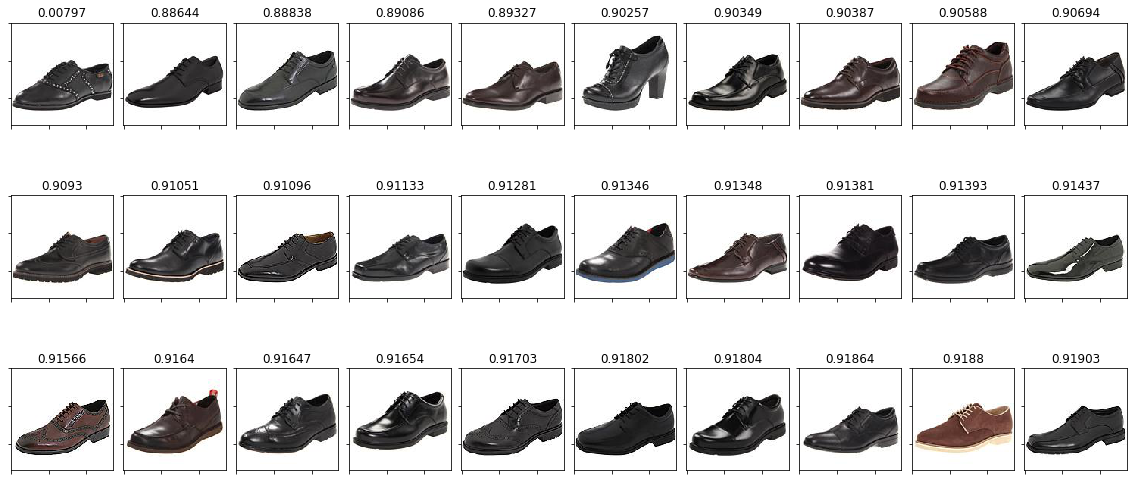

In [32]:
import matplotlib.pyplot as plt

count = 0
columns = 10
BATCHES_TO_DISPLAY = 3

fig = plt.figure(figsize=(columns*2, BATCHES_TO_DISPLAY*3))
fig.subplots_adjust(wspace=.1)

for (index, row) in df[0:columns*BATCHES_TO_DISPLAY].iterrows() :

    count += 1
    ax = fig.add_subplot(BATCHES_TO_DISPLAY, columns, count)   
    ax.set_title(round(row['sim'],5))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(plt.imread(LOCAL_DATA_DIR+'/'+row['img']))
    
plt.show()

### Optional: Automatic Model Tuning 

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

HYPERPARAM_RANGES = {
                        'learning-rate': ContinuousParameter(1e-6, 1e-4),
                        'similarity-dims': CategoricalParameter([16,32,64,96,128]),
                        'optimizer': CategoricalParameter(['Adam','SGD'])
                    }

OBJECTIVE_METRIC_NAME = 'average training loss'
METRIC_DEFINITIONS = [{'Name': 'average training loss',
                       'Regex': 'Training set: Average loss: ([0-9\\.]+)'}]

In [ ]:
from sagemaker.tuner import HyperparameterTuner

PARAM_EPOCHS = 8
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-4
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER
                }

tuned_estimator = PyTorch(entry_point="siamese.py",
                            role=role,
                            framework_version='0.4.0',
                            train_instance_count=1,
                            train_instance_type='ml.p3.2xlarge',
                            source_dir=SOURCE_DIR,
                            base_job_name='HPO-pytorch',
                            hyperparameters=HYPERPARAMETERS)

# Configure HyperparameterTuner
tuner = HyperparameterTuner(estimator=tuned_estimator,
                            objective_metric_name = OBJECTIVE_METRIC_NAME,
                            hyperparameter_ranges  = HYPERPARAM_RANGES,
                            metric_definitions = METRIC_DEFINITIONS,
                            max_jobs=30,
                            max_parallel_jobs=1)

# Start hyperparameter tuning job
#tuner.fit({'train': 's3://'+bucket+prefix, 'test': 's3://my_bucket_my_testing_data'})
tuner.fit({'train': data_s3uri})

In [ ]:
%%bash -s "$DOWNLOAD_S3URI", "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/source/batch_inference.py ./$2

In [ ]:
# Deploy best model
my_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# Make a prediction against the SageMaker endpoint
response = my_predictor.predict(my_prediction_data)

# Tear down the SageMaker endpoint
my_tuner.delete_endpoint()